## Detailed Article Explaination

The detailed code explanation for this article is available at the following link:

https://www.daniweb.com/programming/computer-science/tutorials/543772/working-with-subgraphs-in-langgraph

For my other articles for Daniweb.com, please see this link:

https://www.daniweb.com/members/1235222/usmanmalik57

## Importing and Installing Required Libraries

In [ ]:
!pip install langchain-community
!pip install langchain-openai
!langchain-text-splitters
!pip install langgraph
!langchain-core
!pip install pypdf
!pip install chromadb

/bin/bash: line 1: langchain-text-splitters: command not found
/bin/bash: line 1: langchain-core: command not found


In [ ]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage

from typing_extensions import List, TypedDict
from IPython.display import Image, display
import os

from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

## A Simple Example of Subgraphs in LangGraph

In [ ]:
llm = ChatOpenAI(model = 'gpt-4o',
                api_key = OPENAI_API_KEY)

In [ ]:
class ParentState(TypedDict):
    query: str
    answer: str
    followup: str
    trace: list[str]


class QASubgraphState(TypedDict):
    query: str            # (shared with parent)
    answer: str           # (shared with parent)
    followup: str         # (shared with parent)
    trace: list[str]      # (shared with parent)

In [ ]:
def answer_question(state: QASubgraphState) -> QASubgraphState:
    question = state["query"]
    trace = state.get("trace", [])
    trace.append("subgraph:answer_question")
    response = llm([HumanMessage(content=question)]).content
    return {"answer": response, "trace": trace}

def suggest_followup(state: QASubgraphState) -> QASubgraphState:
    trace = state.get("trace", [])
    trace.append("subgraph:suggest_followup")
    prompt = f"Based on the answer: '{state['answer']}', suggest a relevant follow-up question."
    suggestion = llm([HumanMessage(content=prompt)]).content
    return {"followup": suggestion, "trace": trace}

def parent_node(state: ParentState) -> ParentState:
    trace = state.get("trace", [])
    trace.append("parent:qa_flow")
    return {"trace": trace}

In [ ]:
subgraph_builder = StateGraph(QASubgraphState)
subgraph_builder.add_node("answer_question", answer_question)
subgraph_builder.add_node("suggest_followup", suggest_followup)
subgraph_builder.add_edge(START, "answer_question")
subgraph_builder.add_edge("answer_question", "suggest_followup")
subgraph_builder.add_edge("suggest_followup", END)
qa_subgraph = subgraph_builder.compile()


parent_builder = StateGraph(ParentState)
parent_builder.add_node("parent_node", parent_node)
parent_builder.add_node("qa_flow", qa_subgraph)
parent_builder.add_edge(START, "parent_node")
parent_builder.add_edge("parent_node", "qa_flow")
parent_builder.add_edge("qa_flow", END)

parent_graph = parent_builder.compile()


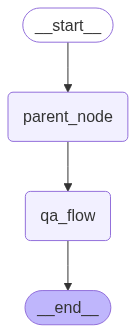

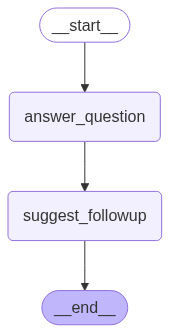

In [ ]:
display(Image(parent_graph.get_graph().draw_mermaid_png()))
display(Image(qa_subgraph.get_graph().draw_mermaid_png()))

In [ ]:
query = "What is the capital of France?"
result_state = parent_graph.invoke({"query": query})

print("Question:", query)
print("Answer:", result_state["answer"])
print("Follow-up question:", result_state["followup"])
print("Nodes tracing", result_state['trace'])

Question: What is the capital of France?
Answer: The capital of France is Paris.
Follow-up question: What are some famous landmarks to visit in Paris?
Nodes tracing ['parent:qa_flow', 'subgraph:answer_question', 'subgraph:suggest_followup']


## RAG with Subgraphs and Conditional Routing

### Define the RAG Subgraph

In [ ]:
data_url = "https://northwestcricket.com/wp-content/uploads/2023/04/laws-of-cricket-2017-code-3rd-edition-2022_1.pdf"

loader = PyPDFLoader(data_url)
docs = loader.load()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Document split into {len(all_splits)} sub-documents.")

Document split into 300 sub-documents.


In [ ]:
embeddings = OpenAIEmbeddings()

vector_store= Chroma.from_documents(
    documents=all_splits,
    embedding=embeddings
)

In [ ]:
class RagState(TypedDict):
    query: str
    answer: str
    docs: str

def retrieve_docs(state: RagState) -> RagState:
    query = state["query"]
    results = vector_store.similarity_search(query)
    context_texts = [doc.page_content for doc in results]
    state_update: RagState = {"docs": " ".join(context_texts)}
    return state_update

def answer_with_docs(state: RagState) -> RagState:
    query = state["query"]
    context = state["docs"]
    prompt = f"Use the following document excerpt to answer the question.\nDocument: {context}\nQuestion: {query}\nAnswer:"
    answer = llm([HumanMessage(content=prompt)]).content
    return {"answer": answer}

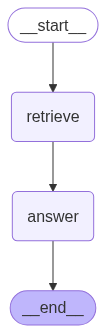

In [ ]:
rag_builder = StateGraph(RagState)
rag_builder.add_node("retrieve", retrieve_docs)
rag_builder.add_node("answer", answer_with_docs)
rag_builder.add_edge(START, "retrieve")
rag_builder.add_edge("retrieve", "answer")
rag_builder.add_edge("answer", END)
rag_subgraph = rag_builder.compile()
display(Image(rag_subgraph.get_graph().draw_mermaid_png()))

In [ ]:
result = rag_subgraph.invoke({"query": "What is the law to take tea when a team is 9 wickets down?"})
print(result['answer'])

The law regarding the tea interval when a team is 9 wickets down is found in Law 11.7 of the document. It states that if either: 
1. 9 wickets are already down when 3 minutes remain to the agreed time for the interval,
2. The 9th wicket falls within this 3 minutes, or
3. At any time up to and including the final ball of the over in progress at the agreed time for the interval,

then the provisions of Law 12.5.2 shall not apply. Instead, the interval will not be taken until the end of the over that is in progress 30 minutes after the originally agreed time for the interval, unless the players have cause to leave the field of play or the innings is completed earlier. The retirement of a batter is not considered equivalent to the fall of a wicket for this rule.


### Define the Direct Answer Node

In [ ]:
class ParentState(TypedDict):
    query: str
    answer: str
    category:str

def direct_answer(state: ParentState) -> ParentState:
    question = state["query"]
    response = llm([HumanMessage(content=question)]).content
    return {"answer": response}

## Routing Logic with a Conditional Edge

In [ ]:
def router_node(state: ParentState) -> ParentState:
    return state["category"]

# Define a routing decision function using the LLM (or simple logic)
def route_decision(state: ParentState) -> str:

    question = state["query"]
    routing_prompt = f"If the question is about crickert sport return `rag`, else return `direct`. Question: {question}. The answer should be a single word."
    analysis = llm([HumanMessage(content=routing_prompt)]).content
    decision = analysis.strip().lower()

    print(f"=========== The query is routed to =========== : {decision}")
    if "rag" in decision:
        return {"category": "rag"}
    else:
        return {"category": "direct"}

## Compose the Parent Graph

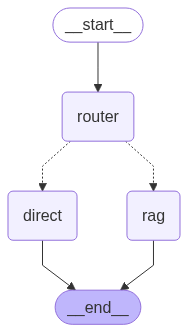

In [ ]:
parent_builder = StateGraph(ParentState)
parent_builder.add_node("router", route_decision)
parent_builder.add_node("direct", direct_answer)
parent_builder.add_node("rag", rag_subgraph)

parent_builder.add_edge(START, "router")
parent_builder.add_conditional_edges(
    "router",
    router_node,
      {"rag": "rag",
       "direct": "direct"}
)

parent_builder.add_edge("direct", END)
parent_builder.add_edge("rag", END)

parent_graph = parent_builder.compile()
display(Image(parent_graph.get_graph().draw_mermaid_png()))

In [ ]:
q1 = "How do I reverse a string in Python? Give only one method"
q2 = "What is the rule to call stumps when a team is 9 wickets down?"

for q in [q1, q2]:
    result = parent_graph.invoke({"query": q})
    print(f"Q: {q}")
    print(f"A: {result['answer']}\n")

=========== The query is routed to =========== : direct
Q: How do I reverse a string in Python? Give only one method
A: You can reverse a string in Python using slicing. Here's how you can do it:

```python
reversed_string = original_string[::-1]
```

This slice notation `[::-1]` effectively takes the original string and steps backwards through it.

=========== The query is routed to =========== : rag
Q: What is the rule to call stumps when a team is 9 wickets down?
A: The document provided does not explicitly mention a rule regarding calling "stumps" when a team is 9 wickets down. The term "stumps" generally refers to the end of a session of play or the end of a day's play. The document focuses on situations related to being "stumped" or other dismissals in cricket like "Run out" and "Timed out." For a team that is 9 wickets down, play would generally continue until the 10th wicket falls (all out), the overs are exhausted, or play is called off due to time or external factors (such as